# WikiChurches Dataset Exploration

This notebook explores the WikiChurches dataset used for SSL attention alignment analysis.

**Dataset Overview:**
- ~9,500 church images with metadata (name, built year, styles, location, country)
- 139 annotated images with 631 bounding boxes
- 106 architectural feature types (Apse, Arcade, Rose Window, etc.)
- 4 main architectural styles: Romanesque, Gothic, Renaissance, Baroque

## 1. Setup & Configuration

In [1]:
import json
import random
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import polars as pl
from PIL import Image

# Configure Polars display
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(50)

# Dataset path (relative to notebook location)
DATASET_PATH = Path("../dataset")

print(f"Polars version: {pl.__version__}")
print(f"Dataset path: {DATASET_PATH.resolve()}")

Polars version: 1.37.1
Dataset path: /Users/desmondchoy/Projects/ssl_wikichurches/dataset


## 2. Load Churches Data

The `churches.json` file contains metadata for all churches in the dataset.
Structure: `{Q-ID: {id, name, built_year, styles, country: {id, name}, location: {lat, lon}}}`

In [2]:
# Load churches JSON (dict-keyed structure)
with open(DATASET_PATH / "churches.json") as f:
    churches_raw = json.load(f)


def normalize_built_year(year_val):
    """Handle built_year which can be int, list, or None.
    For lists (churches built over multiple periods), take the earliest year."""
    if year_val is None:
        return None
    if isinstance(year_val, list):
        return min(year_val) if year_val else None
    return year_val


# Transform to flat records for Polars
churches_records = [
    {
        "id": church["id"],
        "name": church["name"],
        "built_year": normalize_built_year(church["built_year"]),
        "styles": church["styles"],  # Keep as list for now
        "country_id": church["country"]["id"],
        "country_name": church["country"]["name"],
        "lat": church["location"]["lat"],
        "lon": church["location"]["lon"],
    }
    for church in churches_raw.values()
]

churches_df = pl.DataFrame(churches_records)
print(f"Churches loaded: {len(churches_df):,} rows")
churches_df.head()

Churches loaded: 9,346 rows


id,name,built_year,styles,country_id,country_name,lat,lon
str,str,i64,list[str],str,str,f64,f64
"""Q1389""","""St. Cecilia's Church""",1101,"[""Q46261""]","""Q183""","""Germany""",50.934642,6.951736
"""Q1516""","""Basilica of Notre-Dame de Fourvière""",1872,"[""Q186363""]","""Q142""","""France""",45.762292,4.822556
"""Q1521""","""Lyon Cathedral""",1175,"[""Q176483"", ""Q46261""]","""Q142""","""France""",45.760833,4.827222
"""Q2943""","""Sistine Chapel""",null,"[""Q236122""]","""Q237""","""Vatican City""",41.903056,12.454444
"""Q2981""","""Notre Dame de Paris""",1163,"[""Q2245347""]","""Q142""","""France""",48.853,2.3498


In [3]:
# Check schema and types
churches_df.schema

Schema([('id', String),
        ('name', String),
        ('built_year', Int64),
        ('styles', List(String)),
        ('country_id', String),
        ('country_name', String),
        ('lat', Float64),
        ('lon', Float64)])

## 3. Load Feature Types (Meta)

The `building_parts.json` file contains two sections:
- `meta`: List of 106 architectural feature types with parent relationships
- `annotations`: Dict of annotated images with bounding boxes

In [4]:
# Load building parts JSON
with open(DATASET_PATH / "building_parts.json") as f:
    building_parts_raw = json.load(f)

# Extract meta section - feature types
meta_records = [
    {
        "feature_id": idx,
        "name": item["name"],
        "parent_ids": item["parents"],
    }
    for idx, item in enumerate(building_parts_raw["meta"])
]

feature_types_df = pl.DataFrame(meta_records)
print(f"Feature types loaded: {len(feature_types_df)} rows")
feature_types_df.head(10)

Feature types loaded: 106 rows


feature_id,name,parent_ids
i64,str,list[i64]
0,"""Apse""",[]
1,"""Arcade""",[]
2,"""Arcade Gallery""","[1, 51]"
3,"""Arcade Window""","[103, 1]"
4,"""Arch""",[]
5,"""Archivolted Portal""","[79, 72]"
6,"""Balustrade""",[]
7,"""Belt Course""",[29]
8,"""Blind""",[]


In [5]:
# Show all feature type names
feature_types_df.select("feature_id", "name")

feature_id,name
i64,str
0,"""Apse"""
1,"""Arcade"""
2,"""Arcade Gallery"""
3,"""Arcade Window"""
4,"""Arch"""
5,"""Archivolted Portal"""
6,"""Balustrade"""
7,"""Belt Course"""
8,"""Blind"""


## 4. Load Annotations

Flatten the nested `bbox_groups` structure into individual bounding box rows.

In [6]:
# Extract and flatten annotations
annotations_raw = building_parts_raw["annotations"]

bbox_records = []
for image_id, annotation in annotations_raw.items():
    styles = annotation["styles"]
    for group in annotation["bbox_groups"]:
        group_label = group["group_label"]
        for element in group["elements"]:
            bbox_records.append(
                {
                    "image_id": image_id,
                    "styles": styles,
                    "group_label": group_label,
                    "label": element["label"],
                    "left": element["left"],
                    "top": element["top"],
                    "width": element["width"],
                    "height": element["height"],
                }
            )

annotations_df = pl.DataFrame(bbox_records)
print(f"Bounding boxes loaded: {len(annotations_df)} rows")
print(f"Annotated images: {annotations_df['image_id'].n_unique()}")
annotations_df.head()

Bounding boxes loaded: 631 rows
Annotated images: 139


image_id,styles,group_label,label,left,top,width,height
str,list[str],i64,i64,f64,f64,f64,f64
"""Q18785543_wd0.jpg""","[""Q46261""]",83,83,0.451221,0.543788,0.031707,0.117469
"""Q18785543_wd0.jpg""","[""Q46261""]",77,77,0.496342,0.411161,0.097558,0.227359
"""Q2034923_wd0.jpg""","[""Q46261""]",56,56,0.285366,0.249034,0.042683,0.224295
"""Q2034923_wd0.jpg""","[""Q46261""]",72,79,0.346341,0.539298,0.195122,0.156672
"""Q2034923_wd0.jpg""","[""Q46261""]",72,61,0.346345,0.549198,0.195117,0.288609


## 5. Load Style Names

The `style_names.txt` file maps Q-IDs to human-readable style names.

In [7]:
# Parse style_names.txt (format: Q-ID style-name per line)
style_records = []
with open(DATASET_PATH / "style_names.txt") as f:
    for line in f:
        parts = line.strip().split(" ", 1)  # Split on first space only
        if len(parts) == 2:
            style_records.append({"style_qid": parts[0], "style_name": parts[1]})

styles_df = pl.DataFrame(style_records)
print(f"Style names loaded: {len(styles_df)} rows")
styles_df.head(10)

Style names loaded: 121 rows


style_qid,style_name
str,str
"""Q578577""","""Early English Gothic"""
"""Q12049741""","""Romantic Architecture"""
"""Q966571""","""Byzantine Revival Architecture"""
"""Q6092662""","""Italian Baroque"""
"""Q2884586""","""Italian Romanesque Architecture"""
"""Q47942""","""Functionalism"""
"""Q616753""","""Naryshkin Baroque"""
"""Q2864731""","""Romanesque Architecture of Provence"""
"""Q708807""","""Pre-Romanesque Art"""


## 6. Basic Exploration

Examine shape, dtypes, null values, and basic distributions.

In [8]:
# Churches summary
print("=" * 50)
print("CHURCHES DATAFRAME")
print("=" * 50)
print(f"Shape: {churches_df.shape}")
print("\nColumn types:")
for col, dtype in churches_df.schema.items():
    print(f"  {col}: {dtype}")

CHURCHES DATAFRAME
Shape: (9346, 8)

Column types:
  id: String
  name: String
  built_year: Int64
  styles: List(String)
  country_id: String
  country_name: String
  lat: Float64
  lon: Float64


In [9]:
# Null value analysis
null_counts = churches_df.null_count()
print("Null counts per column:")
null_counts

Null counts per column:


id,name,built_year,styles,country_id,country_name,lat,lon
u32,u32,u32,u32,u32,u32,u32,u32
0,0,8046,0,0,0,0,0


In [10]:
# Built year statistics (excluding nulls)
churches_df.filter(pl.col("built_year").is_not_null()).select(
    pl.col("built_year").min().alias("min_year"),
    pl.col("built_year").max().alias("max_year"),
    pl.col("built_year").mean().alias("mean_year"),
    pl.col("built_year").median().alias("median_year"),
)

min_year,max_year,mean_year,median_year
i64,i64,f64,f64
401,2011,1485.300769,1489.5


In [11]:
# Sample data head and tail
print("First 5 churches:")
display(churches_df.head())

print("\nLast 5 churches:")
display(churches_df.tail())

First 5 churches:


id,name,built_year,styles,country_id,country_name,lat,lon
str,str,i64,list[str],str,str,f64,f64
"""Q1389""","""St. Cecilia's Church""",1101,"[""Q46261""]","""Q183""","""Germany""",50.934642,6.951736
"""Q1516""","""Basilica of Notre-Dame de Fourvière""",1872,"[""Q186363""]","""Q142""","""France""",45.762292,4.822556
"""Q1521""","""Lyon Cathedral""",1175,"[""Q176483"", ""Q46261""]","""Q142""","""France""",45.760833,4.827222
"""Q2943""","""Sistine Chapel""",null,"[""Q236122""]","""Q237""","""Vatican City""",41.903056,12.454444
"""Q2981""","""Notre Dame de Paris""",1163,"[""Q2245347""]","""Q142""","""France""",48.853,2.3498



Last 5 churches:


id,name,built_year,styles,country_id,country_name,lat,lon
str,str,i64,list[str],str,str,f64,f64
"""Q32860795""","""Parochiekerk Sint-Ursula""",1843,"[""Q54111""]","""Q31""","""Belgium""",50.831662,4.140596
"""Q32917919""","""Parochiekerk Onze-Lieve-Vrouw""",1265,"[""Q176483""]","""Q31""","""Belgium""",50.822154,4.114077
"""Q32922716""","""Parochiekerk Sint-Pieter""",1400,"[""Q4198718""]","""Q31""","""Belgium""",50.779151,4.243488
"""Q32945299""","""Parochiekerk Sint-Pieter in Banden""",1910,"[""Q186363""]","""Q31""","""Belgium""",50.780958,4.199275
"""Q32945303""","""Parochiekerk Sint-Amandus""",1875,"[""Q186363""]","""Q31""","""Belgium""",50.779585,4.171


## 7. Churches Analysis

In [12]:
# Built year distribution by century
century_dist = (
    churches_df.filter(pl.col("built_year").is_not_null())
    .with_columns(century=((pl.col("built_year") // 100) * 100))
    .group_by("century")
    .agg(pl.len().alias("count"))
    .sort("century")
)

print("Churches by century:")
century_dist

Churches by century:


century,count
i64,u32
400,13
500,13
600,14
700,6
800,14
900,17
1000,76
1100,161
1200,129


In [13]:
# Geographic distribution by country (top 20)
country_dist = (
    churches_df.group_by("country_name")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(20)
)

print("Top 20 countries by church count:")
country_dist

Top 20 countries by church count:


country_name,count
str,u32
"""Germany""",3557
"""France""",1063
"""United Kingdom""",943
"""Spain""",717
"""Italy""",538
"""Austria""",485
"""Czech Republic""",418
"""Belgium""",256
"""Switzerland""",239


In [14]:
# Explode styles to analyze individual style occurrences
# Note: styles column is a list, we need to explode it
churches_exploded = churches_df.explode("styles")

# Count style occurrences and join with style names
style_counts = (
    churches_exploded.group_by("styles")
    .agg(pl.len().alias("count"))
    .join(styles_df, left_on="styles", right_on="style_qid", how="left")
    .sort("count", descending=True)
)

print("Top 20 architectural styles:")
style_counts.head(20)

Top 20 architectural styles:


styles,count,style_name
str,u32,str
"""Q46261""",1680,"""Romanesque"""
"""Q176483""",1644,"""Gothic"""
"""Q186363""",1636,"""Gothic Revival Architecture"""
"""Q840829""",1457,"""Baroque"""
"""Q245188""",500,"""Modern Architecture"""
"""Q744373""",492,"""Romanesque Revival Architecture"""
"""Q54111""",381,"""Neoclassical Architecture"""
"""Q695863""",272,"""Brick Gothic"""
"""Q750752""",223,"""English Gothic"""


In [15]:
# Churches with multiple styles
multi_style_churches = churches_df.with_columns(num_styles=pl.col("styles").list.len()).filter(
    pl.col("num_styles") > 1
)

print(f"Churches with multiple styles: {len(multi_style_churches):,}")
print(
    f"  (out of {len(churches_df):,} total, {100 * len(multi_style_churches) / len(churches_df):.1f}%)"
)

# Distribution of style counts
style_count_dist = (
    churches_df.with_columns(num_styles=pl.col("styles").list.len())
    .group_by("num_styles")
    .agg(pl.len().alias("count"))
    .sort("num_styles")
)
print("\nDistribution of styles per church:")
style_count_dist

Churches with multiple styles: 433
  (out of 9,346 total, 4.6%)

Distribution of styles per church:


num_styles,count
u32,u32
1,8913
2,391
3,41
4,1


## 8. Annotations Analysis

In [16]:
# Bounding boxes per image
bboxes_per_image = annotations_df.group_by("image_id").agg(pl.len().alias("bbox_count"))

print("Bboxes per image statistics:")
bboxes_per_image.select(
    pl.col("bbox_count").min().alias("min"),
    pl.col("bbox_count").max().alias("max"),
    pl.col("bbox_count").mean().alias("mean"),
    pl.col("bbox_count").median().alias("median"),
)

Bboxes per image statistics:


min,max,mean,median
u32,u32,f64,f64
1,10,4.539568,4.0


In [17]:
# Feature type frequency in annotations
feature_freq = (
    annotations_df.group_by("label")
    .agg(pl.len().alias("count"))
    .join(feature_types_df, left_on="label", right_on="feature_id", how="left")
    .sort("count", descending=True)
)

print("Top 20 most annotated feature types:")
feature_freq.head(20)

Top 20 most annotated feature types:


label,count,name,parent_ids
i64,u32,str,list[i64]
83,38,"""Round Arch Window""","[79, 103]"
71,37,"""Pointed Arch Window""","[68, 103]"
22,31,"""Buttress""",[24]
65,28,"""Pinnacle""",[]
91,25,"""Tracery""",[]
57,24,"""Lombard Band""","[50, 10]"
92,21,"""Tracery Rose Window""",[93]
64,20,"""Pilaster""",[24]
97,19,"""Triangular Pediment""",[63]


In [18]:
# Style distribution in annotated images
annotated_styles = (
    annotations_df.select("image_id", "styles")
    .unique()
    .explode("styles")
    .group_by("styles")
    .agg(pl.len().alias("image_count"))
    .join(styles_df, left_on="styles", right_on="style_qid", how="left")
    .sort("image_count", descending=True)
)

print("Style distribution in annotated subset:")
annotated_styles

Style distribution in annotated subset:


styles,image_count,style_name
str,u32,str
"""Q46261""",54,"""Romanesque"""
"""Q176483""",49,"""Gothic"""
"""Q236122""",22,"""Renaissance"""
"""Q840829""",17,"""Baroque"""


In [19]:
# Bbox size statistics
print("Bounding box size statistics (normalized coordinates 0-1):")
annotations_df.select(
    pl.col("width").min().alias("min_width"),
    pl.col("width").max().alias("max_width"),
    pl.col("width").mean().alias("mean_width"),
    pl.col("height").min().alias("min_height"),
    pl.col("height").max().alias("max_height"),
    pl.col("height").mean().alias("mean_height"),
)

Bounding box size statistics (normalized coordinates 0-1):


min_width,max_width,mean_width,min_height,max_height,mean_height
f64,f64,f64,f64,f64,f64
0.008536,0.984396,0.124701,0.009756,0.653712,0.131962


In [20]:
# Bbox area distribution
bbox_areas = annotations_df.with_columns(area=(pl.col("width") * pl.col("height")))

print("Bbox area statistics (as fraction of image):")
bbox_areas.select(
    pl.col("area").min().alias("min_area"),
    pl.col("area").max().alias("max_area"),
    pl.col("area").mean().alias("mean_area"),
    pl.col("area").median().alias("median_area"),
)

Bbox area statistics (as fraction of image):


min_area,max_area,mean_area,median_area
f64,f64,f64,f64
0.00016,0.211808,0.017471,0.007611


## 9. Cross-Dataset Analysis

In [21]:
# Extract Q-ID from image_id (format: Q12345_wd0.jpg -> Q12345)
annotated_qids = (
    annotations_df.select("image_id")
    .unique()
    .with_columns(qid=pl.col("image_id").str.extract(r"(Q\d+)"))
)

# Join with churches data
annotated_churches = annotated_qids.join(churches_df, left_on="qid", right_on="id", how="left")

print(
    f"Annotated churches matched: {annotated_churches.filter(pl.col('name').is_not_null()).height}"
)
print(f"Unmatched: {annotated_churches.filter(pl.col('name').is_null()).height}")
annotated_churches.filter(pl.col("name").is_not_null()).head(10)

Annotated churches matched: 139
Unmatched: 0


image_id,qid,name,built_year,styles,country_id,country_name,lat,lon
str,str,str,i64,list[str],str,str,f64,f64
"""Q794876_wd0.jpg""","""Q794876""","""San Zaccaria""",1458,"[""Q236122""]","""Q38""","""Italy""",45.434722,12.343333
"""Q3585324_wd0.jpg""","""Q3585324""","""Church of San Clemente""",null,"[""Q236122""]","""Q38""","""Italy""",45.4121,12.3356
"""Q744420_wd0.jpg""","""Q744420""","""Burgos Cathedral""",1221,"[""Q176483""]","""Q29""","""Spain""",42.340806,-3.704472
"""Q1631593_wd0.jpg""","""Q1631593""","""Sant'Andrea della Valle""",null,"[""Q236122"", ""Q840829""]","""Q38""","""Italy""",41.895833,12.474444
"""Q1340432_wd0.jpg""","""Q1340432""","""collégiale Notre-Dame de Montréal""",null,"[""Q46261""]","""Q142""","""France""",47.54614,4.036864
"""Q589462_wd0.jpg""","""Q589462""","""Santa Maria presso San Satiro""",1401,"[""Q236122""]","""Q38""","""Italy""",45.462647,9.188033
"""Q24254219_wd0.jpg""","""Q24254219""","""chiesa di Santa Grata inter Vites""",null,"[""Q840829""]","""Q38""","""Italy""",45.706711,9.654661
"""Q1710328_wd0.jpg""","""Q1710328""","""église Saint-Sulpice de Saint-Sulpice-de-Favières""",null,"[""Q176483""]","""Q142""","""France""",48.541306,2.178972
"""Q2320951_wd0.jpg""","""Q2320951""","""St. Mariä Heimsuchung""",null,"[""Q176483""]","""Q183""","""Germany""",50.7922,6.57083


In [22]:
# Characteristics of annotated churches vs all churches
print("Annotated churches built year range:")
matched_churches = annotated_churches.filter(pl.col("built_year").is_not_null())
if len(matched_churches) > 0:
    display(
        matched_churches.select(
            pl.col("built_year").min().alias("min_year"),
            pl.col("built_year").max().alias("max_year"),
            pl.col("built_year").mean().alias("mean_year"),
        )
    )

print("\nCountry distribution of annotated churches:")
(
    annotated_churches.filter(pl.col("country_name").is_not_null())
    .group_by("country_name")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

Annotated churches built year range:


min_year,max_year,mean_year
i64,i64,f64
553,1740,1218.787234



Country distribution of annotated churches:


country_name,count
str,u32
"""France""",44
"""Germany""",30
"""Italy""",29
"""United Kingdom""",11
"""Spain""",8
"""Belgium""",6
"""Czech Republic""",3
"""Poland""",3
"""Hungary""",1


In [23]:
# Feature types by architectural style
# Join annotations with style names to see which features appear in which styles
style_features = (
    annotations_df.explode("styles")
    .join(styles_df, left_on="styles", right_on="style_qid", how="left")
    .join(feature_types_df, left_on="label", right_on="feature_id", how="left")
    .group_by("style_name", "name")
    .agg(pl.len().alias("count"))
    .sort("style_name", "count", descending=[False, True])
)

print("Top 5 features per style:")
for style in style_features.select("style_name").unique().to_series().to_list():
    if style is not None:
        print(f"\n{style}:")
        display(style_features.filter(pl.col("style_name") == style).head(5))

Top 5 features per style:

Baroque:


style_name,name,count
str,str,u32
"""Baroque""","""Volute""",6
"""Baroque""","""Cranked Pediment""",5
"""Baroque""","""Pilaster""",5
"""Baroque""","""Balustrade""",4
"""Baroque""","""Broken Pediment""",3



Gothic:


style_name,name,count
str,str,u32
"""Gothic""","""Pointed Arch Window""",37
"""Gothic""","""Buttress""",31
"""Gothic""","""Pinnacle""",28
"""Gothic""","""Tracery""",25
"""Gothic""","""Tracery Rose Window""",21



Renaissance:


style_name,name,count
str,str,u32
"""Renaissance""","""Triangular Pediment""",19
"""Renaissance""","""Pilaster""",15
"""Renaissance""","""Belt Course""",9
"""Renaissance""","""Round Arch Niche""",7
"""Renaissance""","""Segmental Pediment""",7



Romanesque:


style_name,name,count
str,str,u32
"""Romanesque""","""Round Arch Window""",38
"""Romanesque""","""Lombard Band""",24
"""Romanesque""","""Dentil""",14
"""Romanesque""","""Lesene""",13
"""Romanesque""","""Columned Portal""",12


## 10. Your Custom Exploration

This section is prepared for you to write your own exploration query. The DataFrames are ready:

- `churches_df`: All churches (id, name, built_year, styles, country_name, lat, lon)
- `feature_types_df`: Feature types (feature_id, name, parent_ids)
- `annotations_df`: Bounding boxes (image_id, styles, group_label, label, left, top, width, height)
- `styles_df`: Style names (style_qid, style_name)

**Ideas to explore:**
- Which architectural features co-occur most frequently?
- Are certain features more common in specific geographic regions?
- How do bbox sizes vary by feature type (do Rose Windows tend to be larger than Buttresses)?
- What's the parent-child hierarchy of feature types?

In [24]:
# TODO: Write your custom exploration query here
#
# Example: Find the average bbox area by feature type
# (
#     annotations_df
#     .with_columns(area=(pl.col("width") * pl.col("height")))
#     .group_by("label")
#     .agg(pl.col("area").mean().alias("mean_area"))
#     .join(feature_types_df, left_on="label", right_on="feature_id")
#     .sort("mean_area", descending=True)
# )

pass  # Replace with your exploration

## Summary

This notebook loaded and explored the WikiChurches dataset:

| Dataset | Rows | Key Columns |
|---------|------|-------------|
| Churches | ~9,500 | id, name, built_year, styles, country, location |
| Feature Types | 106 | feature_id, name, parent_ids |
| Annotations | ~631 bboxes | image_id, label, left/top/width/height |
| Style Names | ~121 | style_qid, style_name |

**Key findings:**
- Built years range from ancient to modern, with peaks in medieval period
- Geographic distribution heavily weighted toward European countries
- Gothic and Romanesque are the dominant architectural styles
- Annotated subset focuses on the 4 main styles with varying feature distributions

## 11. Image Visualization with Annotations

Display random church images with bounding box overlays. Filter by feature type, architectural style, or country.

In [25]:
# Color palette for different feature groups
FEATURE_COLORS = {
    0: "#e74c3c",  # Red
    1: "#3498db",  # Blue
    2: "#2ecc71",  # Green
    3: "#f39c12",  # Orange
    4: "#9b59b6",  # Purple
    5: "#1abc9c",  # Teal
    6: "#e91e63",  # Pink
    7: "#00bcd4",  # Cyan
}


def get_feature_color(label: int) -> str:
    """Get a color for a feature label (cycles through palette)."""
    return FEATURE_COLORS[label % len(FEATURE_COLORS)]


def display_annotated_image(
    image_id: str,
    annotations: pl.DataFrame,
    feature_types: pl.DataFrame,
    highlight_labels: list[int] | None = None,
    figsize: tuple = (12, 10),
) -> None:
    """
    Display an image with bounding box annotations overlaid.

    Args:
        image_id: The image filename (e.g., "Q12345_wd0.jpg")
        annotations: DataFrame with bbox data for this image
        feature_types: DataFrame mapping label IDs to names
        highlight_labels: If provided, only highlight these label IDs (others shown dimmed)
        figsize: Figure size for matplotlib
    """
    # Load image
    image_path = DATASET_PATH / "images" / image_id
    if not image_path.exists():
        print(f"Image not found: {image_path}")
        return

    img = Image.open(image_path)
    img_width, img_height = img.size

    # Get annotations for this image
    img_annotations = annotations.filter(pl.col("image_id") == image_id)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)

    # Draw bounding boxes
    for row in img_annotations.iter_rows(named=True):
        label = row["label"]

        # Convert normalized coords to pixel coords
        left = row["left"] * img_width
        top = row["top"] * img_height
        width = row["width"] * img_width
        height = row["height"] * img_height

        # Get feature name
        feature_name = (
            feature_types.filter(pl.col("feature_id") == label).select("name").item()
            if label is not None
            else "Unknown"
        )

        # Determine color and alpha
        color = get_feature_color(label)
        alpha = 1.0 if highlight_labels is None or label in highlight_labels else 0.3
        linewidth = 2.5 if alpha == 1.0 else 1.0

        # Draw rectangle
        rect = patches.Rectangle(
            (left, top),
            width,
            height,
            linewidth=linewidth,
            edgecolor=color,
            facecolor="none",
            alpha=alpha,
        )
        ax.add_patch(rect)

        # Add label text (only for highlighted or all if no highlight)
        if alpha == 1.0:
            ax.text(
                left,
                top - 5,
                feature_name,
                fontsize=9,
                color="white",
                backgroundcolor=color,
                alpha=0.9,
            )

    # Get style names for title
    style_names = []
    if len(img_annotations) > 0:
        # Extract the styles list from the first row
        styles_list = img_annotations.row(0, named=True)["styles"]
        if styles_list:
            for s in styles_list:
                match = styles_df.filter(pl.col("style_qid") == s)
                if len(match) > 0:
                    style_names.append(match.select("style_name").item())

    ax.set_title(f"{image_id}\nStyles: {', '.join(style_names) if style_names else 'Unknown'}")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


print("Visualization utilities loaded ✓")

Visualization utilities loaded ✓


### 11.1 Random Annotated Image

Display a random annotated church image with all bounding boxes. **Re-run this cell for a new random image.**

Showing: Q2887149_wd0.jpg
Total annotated images: 139


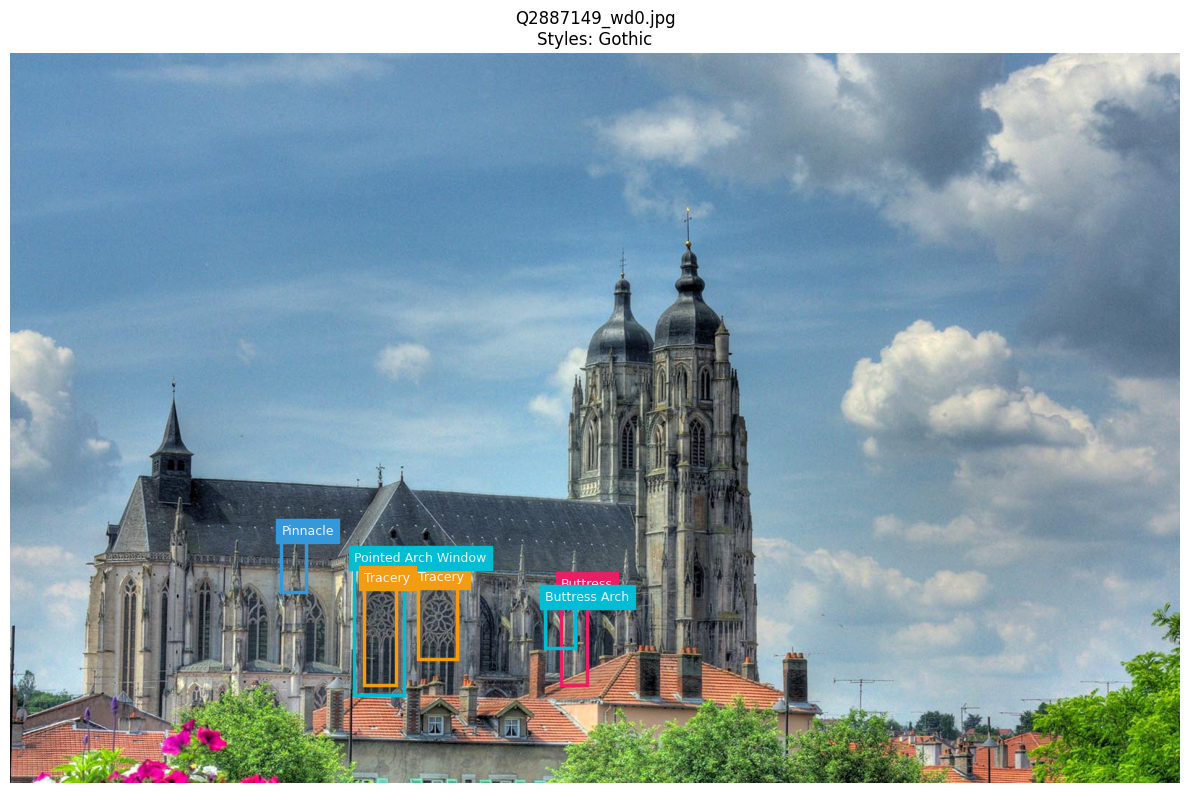

In [26]:
# Pick a random annotated image
all_image_ids = annotations_df.select("image_id").unique().to_series().to_list()
random_image_id = random.choice(all_image_ids)

print(f"Showing: {random_image_id}")
print(f"Total annotated images: {len(all_image_ids)}")

display_annotated_image(random_image_id, annotations_df, feature_types_df)

### 11.2 Random Image by Feature Type

Filter to images containing a specific architectural feature, then display a random one with that feature highlighted.

In [ ]:
# ========== CHANGE THIS TO EXPLORE DIFFERENT FEATURES ==========
FEATURE_NAME = "Tracery Rose Window"  # Try: "Buttress", "Apse", "Pinnacle", "Arcade", "Dome"
# ================================================================

# Find feature ID from name
feature_match = feature_types_df.filter(pl.col("name") == FEATURE_NAME)
if len(feature_match) == 0:
    print(f"Feature '{FEATURE_NAME}' not found. Available features:")
    print(feature_types_df.select("name").to_series().to_list())
else:
    feature_id = feature_match.select("feature_id").item()

    # Find images containing this feature
    images_with_feature = (
        annotations_df.filter(pl.col("label") == feature_id)
        .select("image_id")
        .unique()
        .to_series()
        .to_list()
    )

    print(f"Feature: {FEATURE_NAME} (ID: {feature_id})")
    print(f"Found in {len(images_with_feature)} images")

    if images_with_feature:
        random_image = random.choice(images_with_feature)
        display_annotated_image(
            random_image,
            annotations_df,
            feature_types_df,
            highlight_labels=[feature_id],  # Highlight only this feature
        )

### 11.3 Random Image by Architectural Style

Filter to images of a specific architectural style (Gothic, Romanesque, etc.).

In [ ]:
# ========== CHANGE THIS TO EXPLORE DIFFERENT STYLES ==========
STYLE_NAME = "Gothic"  # Try: "Romanesque", "Baroque", "Renaissance"
# ==============================================================

# Find style Q-ID from name
style_match = styles_df.filter(pl.col("style_name") == STYLE_NAME)
if len(style_match) == 0:
    print(f"Style '{STYLE_NAME}' not found. Available styles in annotations:")
    annotated_style_qids = (
        annotations_df.explode("styles").select("styles").unique().to_series().to_list()
    )
    available_styles = styles_df.filter(pl.col("style_qid").is_in(annotated_style_qids))
    print(available_styles.select("style_name").to_series().to_list())
else:
    style_qid = style_match.select("style_qid").item()

    # Find images with this style
    images_with_style = (
        annotations_df.filter(pl.col("styles").list.contains(style_qid))
        .select("image_id")
        .unique()
        .to_series()
        .to_list()
    )

    print(f"Style: {STYLE_NAME} (QID: {style_qid})")
    print(f"Found {len(images_with_style)} annotated images")

    if images_with_style:
        random_image = random.choice(images_with_style)
        display_annotated_image(random_image, annotations_df, feature_types_df)

### 11.4 Random Image by Country

Filter to churches from a specific country by joining annotations with church metadata.

Country: Germany
Found 30 annotated images
Church: St. Lorenz Basilica


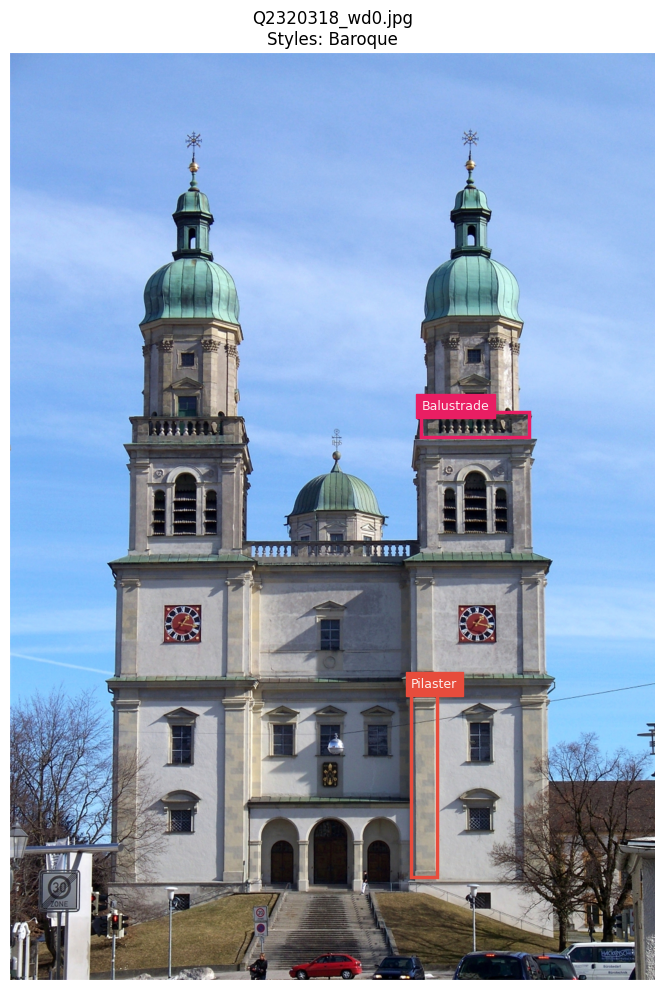

In [29]:
# ========== CHANGE THIS TO EXPLORE DIFFERENT COUNTRIES ==========
COUNTRY_NAME = "Germany"  # Try: "France", "Italy", "Spain", "United Kingdom"
# =================================================================

# Extract Q-ID from image_id and join with churches
annotated_with_country = (
    annotations_df.select("image_id")
    .unique()
    .with_columns(qid=pl.col("image_id").str.extract(r"(Q\d+)"))
    .join(
        churches_df.select("id", "country_name", "name"), left_on="qid", right_on="id", how="left"
    )
)

# Filter by country
images_from_country = (
    annotated_with_country.filter(pl.col("country_name") == COUNTRY_NAME)
    .select("image_id")
    .to_series()
    .to_list()
)

# Show available countries if not found
if not images_from_country:
    print(f"No annotated churches found in '{COUNTRY_NAME}'.")
    print("\nCountries with annotated churches:")
    country_counts = (
        annotated_with_country.filter(pl.col("country_name").is_not_null())
        .group_by("country_name")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    print(country_counts)
else:
    print(f"Country: {COUNTRY_NAME}")
    print(f"Found {len(images_from_country)} annotated images")

    random_image = random.choice(images_from_country)

    # Get church name for context
    church_info = annotated_with_country.filter(pl.col("image_id") == random_image)
    church_name = church_info.select("name").item() if len(church_info) > 0 else "Unknown"
    print(f"Church: {church_name}")

    display_annotated_image(random_image, annotations_df, feature_types_df)